In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [129]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_, or_, not_

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)


In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_temps = calc_temps('2017-01-01','2017-08-01')
print(year_temps)

[(58.0, 73.81984732824428, 87.0)]


In [50]:
tmax = year_temps[0][2]
tmin = year_temps[0][0]
tavg = year_temps[0][1]

Text(0, 0.5, 'Avg temp')

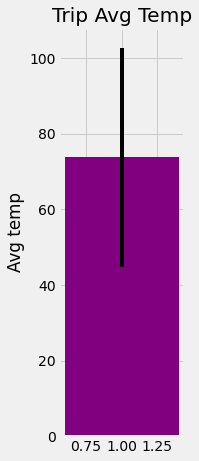

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 7))
y_axis = (tavg)
yerr_bar = tmax- tmin
plt.bar(x = 1,height=y_axis,color = "Purple",yerr = yerr_bar)
plt.title("Trip Avg Temp")
plt.ylabel("Avg temp")

### Daily Rainfall Average

In [181]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station=session.query(func.sum(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station==Station.station).filter(Measurement.date >= '2015-06-01').filter(Measurement.date <= '2016-05-31').\
        group_by (Measurement.station). order_by (func.sum(Measurement.prcp).desc()).all()
rain_station

[(161.27000000000012, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (85.40000000000002, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (56.77000000000001, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (50.540000000000006, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (41.420000000000016, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (16.719999999999988, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (4.380000000000001, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (3.7800000000000002, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (0.0, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [98]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date,end= end_date)
date_range =date_range.strftime('%Y-%m-%d')
date_range

Index(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
       '2017-08-06', '2017-08-07'],
      dtype='object')

In [174]:
# Strip off the year and save a list of strings in the format %m-%d
strip_date = []
for date in date_range:
    dates_new = '{:%m-%d}'.format(dt.strptime(date, '%Y-%m-%d'))
    strip_date.append(dates_new)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals= []
for date in strip_date:
    daily = daily_normals(date)
    normals.append(list(np.ravel(daily)))
normals    


[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [176]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df=pd.DataFrame(normals, index=date_range, columns=['tmin','tavg','tmax'])
trip_df

,tmin,tavg,tmax
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


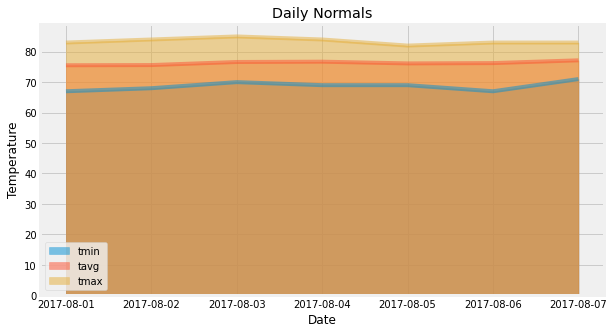

<Figure size 432x288 with 0 Axes>

In [180]:
# Plot the daily normals as an area plot with `stacked=False`
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot.area(stacked=False,figsize = (9,5))
plt.title('Daily Normals')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()
plt.tight_layout()

## Close Session

In [182]:
session.close()